In [ ]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import glob

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

from keras import backend as K
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load county data
data = pd.DataFrame()

# Insert relevant path here
state_csv = 'drive/My Drive/CMU/overall-state.csv'
data = pd.read_csv(state_csv, low_memory=False)

data = data[['date', 'state_code', 'gender', 'age_bucket', 'n', 'weight_sums', 'pct_cli', 'pct_ili', 'pct_cli_anosmia_ageusia', 'pct_hh_cli', 'pct_cmnty_cli', 'pct_hh_fever', 'pct_hh_sore_throat', 'pct_hh_cough', 'pct_hh_shortness_of_breath', 'pct_hh_difficulty_breathing', 'mean_hh_cli_ct', 'mean_cmnty_cli_ct', 'pct_self_fever', 'pct_self_cough', 'pct_self_shortness_of_breath', 'pct_self_difficulty_breathing', 'pct_self_tiredness_or_exhaustion', 'pct_self_nasal_congestion', 'pct_self_runny_nose', 'pct_self_muscle_joint_aches', 'pct_self_sore_throat', 'pct_self_persistent_pain_pressure_in_chest', 'pct_self_nausea_vomiting', 'pct_self_diarrhea', 'pct_self_anosmia_ageusia', 'pct_self_other', 'pct_self_none_of_above', 'pct_self_multiple_symptoms', 'pct_tested_and_positive', 'pct_tested_and_negative', 'pct_tested_no_result', 'pct_could_not_get_tested', 'pct_did_not_try_to_get_tested', 'pct_worked_outside_home', 'pct_avoid_contact_all_or_most_time', 'mean_outside_hh_contact_at_work_ct', 'mean_outside_hh_contact_shopping_ct', 'mean_outside_hh_contact_in_social_gatherings_ct', 'pct_contact_covid_positive', 'pct_diabetes', 'pct_cancer', 'pct_heart_disease', 'pct_high_blood_pressure', 'pct_asthma', 'pct_chronic_lung_disease', 'pct_kidney_disease', 'pct_autoimmune_disorder', 'pct_no_above_medical_conditions', 'pct_multiple_medical_conditions', 'pct_cli_weighted', 'pct_ili_weighted', 'pct_cli_anosmia_ageusia_weighted', 'pct_hh_cli_weighted', 'pct_cmnty_cli_weighted', 'pct_hh_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_hh_cough_weighted', 'pct_hh_shortness_of_breath_weighted', 'pct_hh_difficulty_breathing_weighted', 'mean_hh_cli_ct_weighted', 'mean_cmnty_cli_ct_weighted', 'pct_self_fever_weighted', 'pct_self_cough_weighted', 'pct_self_shortness_of_breath_weighted', 'pct_self_difficulty_breathing_weighted', 'pct_self_tiredness_or_exhaustion_weighted', 'pct_self_nasal_congestion_weighted', 'pct_self_runny_nose_weighted', 'pct_self_muscle_joint_aches_weighted', 'pct_self_sore_throat_weighted', 'pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_nausea_vomiting_weighted', 'pct_self_diarrhea_weighted', 'pct_self_anosmia_ageusia_weighted', 'pct_self_other_weighted', 'pct_self_none_of_above_weighted', 'pct_self_multiple_symptoms_weighted', 'pct_tested_and_positive_weighted', 'pct_tested_and_negative_weighted', 'pct_tested_no_result_weighted', 'pct_could_not_get_tested_weighted', 'pct_did_not_try_to_get_tested_weighted', 'pct_worked_outside_home_weighted', 'pct_avoid_contact_all_or_most_time_weighted', 'mean_outside_hh_contact_at_work_ct_weighted', 'mean_outside_hh_contact_shopping_ct_weighted', 'mean_outside_hh_contact_in_social_gatherings_ct_weighted', 'pct_contact_covid_positive_weighted', 'pct_diabetes_weighted', 'pct_cancer_weighted', 'pct_heart_disease_weighted', 'pct_high_blood_pressure_weighted', 'pct_asthma_weighted', 'pct_chronic_lung_disease_weighted', 'pct_kidney_disease_weighted', 'pct_autoimmune_disorder_weighted', 'pct_no_above_medical_conditions_weighted', 'pct_multiple_medical_conditions_weighted']]

           

### Loading WHO data (Actual cases)

In [ ]:
who = pd.read_csv('drive/My Drive/CMU/refined-us-states.csv')
who.head()

,date,state,cases
0,13-03-2020,al,6
1,14-03-2020,al,12
2,15-03-2020,al,23
3,16-03-2020,al,29
4,17-03-2020,al,39


In [ ]:
who = who.rename(columns={"state": "state_code"})
who['date'] = list(map(lambda x : '-'.join(list(reversed(x.split('-')))) ,list(who['date'])) )
who['daily_case'] = who['cases'].diff().fillna(who['cases'].iloc[0])
data = pd.merge(data, who,  how='inner', on=['date','state_code'] )
data.head()

,date,state_code,gender,age_bucket,n,weight_sums,pct_cli,pct_ili,pct_cli_anosmia_ageusia,pct_hh_cli,pct_cmnty_cli,pct_hh_fever,pct_hh_sore_throat,pct_hh_cough,pct_hh_shortness_of_breath,pct_hh_difficulty_breathing,mean_hh_cli_ct,mean_cmnty_cli_ct,pct_self_fever,pct_self_cough,pct_self_shortness_of_breath,pct_self_difficulty_breathing,pct_self_tiredness_or_exhaustion,pct_self_nasal_congestion,pct_self_runny_nose,pct_self_muscle_joint_aches,pct_self_sore_throat,pct_self_persistent_pain_pressure_in_chest,pct_self_nausea_vomiting,pct_self_diarrhea,pct_self_anosmia_ageusia,pct_self_other,pct_self_none_of_above,pct_self_multiple_symptoms,pct_tested_and_positive,pct_tested_and_negative,pct_tested_no_result,pct_could_not_get_tested,pct_did_not_try_to_get_tested,pct_worked_outside_home,...,mean_cmnty_cli_ct_weighted,pct_self_fever_weighted,pct_self_cough_weighted,pct_self_shortness_of_breath_weighted,pct_self_difficulty_breathing_weighted,pct_self_tiredness_or_exhaustion_weighted,pct_self_nasal_congestion_weighted,pct_self_runny_nose_weighted,pct_self_muscle_joint_aches_weighted,pct_self_sore_throat_weighted,pct_self_persistent_pain_pressure_in_chest_weighted,pct_self_nausea_vomiting_weighted,pct_self_diarrhea_weighted,pct_self_anosmia_ageusia_weighted,pct_self_other_weighted,pct_self_none_of_above_weighted,pct_self_multiple_symptoms_weighted,pct_tested_and_positive_weighted,pct_tested_and_negative_weighted,pct_tested_no_result_weighted,pct_could_not_get_tested_weighted,pct_did_not_try_to_get_tested_weighted,pct_worked_outside_home_weighted,pct_avoid_contact_all_or_most_time_weighted,mean_outside_hh_contact_at_work_ct_weighted,mean_outside_hh_contact_shopping_ct_weighted,mean_outside_hh_contact_in_social_gatherings_ct_weighted,pct_contact_covid_positive_weighted,pct_diabetes_weighted,pct_cancer_weighted,pct_heart_disease_weighted,pct_high_blood_pressure_weighted,pct_asthma_weighted,pct_chronic_lung_disease_weighted,pct_kidney_disease_weighted,pct_autoimmune_disorder_weighted,pct_no_above_medical_conditions_weighted,pct_multiple_medical_conditions_weighted,cases,daily_case
0,2020-04-06,ak,female,18-34,119,78755.310877,0.8772,0.8772,2.6316,0.8403,NaN,1.6807,10.0840,25.2101,7.5630,5.8824,NaN,NaN,0.8772,21.0526,7.8947,5.2632,24.5614,23.6842,25.4386,17.5439,10.5263,6.1404,3.5088,8.7719,1.7544,5.2632,45.6140,36.1345,0.0,8.0645,1.6129,6.4516,83.8710,41.1765,...,0.0,0.6736,23.3022,7.7638,5.0967,26.1142,23.4845,27.9131,18.2524,10.6775,5.5208,2.6801,8.5647,1.9383,5.4658,40.6652,41.9760,0.0,4.6233,0.9214,2.4356,48.8476,40.8441,74.5504,10.4550,6.3869,0.7958,0.0,3.1304,0.0000,0.0000,7.1685,28.7123,0.0000,0.0,9.3777,63.1666,10.3406,189,6.0
1,2020-04-06,ak,female,35-54,95,63666.933392,3.2258,3.2258,3.2258,3.1579,NaN,3.1579,14.7368,21.0526,7.3684,4.2105,NaN,NaN,3.2258,18.2796,4.3011,3.2258,19.3548,9.6774,17.2043,9.6774,11.8280,4.3011,3.2258,5.3763,0.0000,10.7527,53.7634,30.5263,0.0,0.0000,0.0000,4.6512,95.3488,29.4737,...,0.0,4.0793,19.8077,5.8325,3.3564,18.1476,10.1597,16.2840,10.5732,14.0980,5.5914,3.1735,5.2914,0.0000,9.8190,54.8124,29.6202,0.0,0.0000,0.0000,2.5222,40.7606,30.1121,81.7592,5.1141,1.4847,0.1233,0.0,9.7745,2.8142,6.9796,33.3235,29.5650,1.4395,0.0,11.1606,46.8402,25.1121,189,6.0
2,2020-04-06,ak,female,55+,51,52710.069695,0.0000,0.0000,1.9608,0.0000,NaN,0.0000,3.9216,21.5686,7.8431,1.9608,NaN,NaN,0.0000,17.6471,7.8431,0.0000,11.7647,15.6863,13.7255,9.8039,3.9216,5.8824,1.9608,7.8431,1.9608,9.8039,56.8627,25.4902,0.0,4.5455,0.0000,9.0909,86.3636,24.0000,...,0.0,0.0000,15.2620,7.4176,0.0000,10.6149,15.1401,17.2272,11.4370,3.3577,4.3787,1.1577,6.1265,1.1577,12.8193,52.2573,25.9567,0.0,1.3725,0.0000,3.0342,43.3359,19.1636,90.0037,0.2934,1.0323,0.0000,0.0,6.9947,19.3862,1.9712,26.1060,18.2128,6.3439,0.0,8.1722,35.4451,22.9556,189,6.0
3,2020-04-06,ak,female,overall,265,195132.313964,1.5504,1.5504,2.7132,1.5094,NaN,1.8868,10.5660,23.0189,7.5472,4.5283,NaN,NaN,1.5504,19.3798,6.5891,3.4884,20.1550,17.0543,20.1550,13.1783,9.6899,5.4264,3.1008,7.3

Time Series Data Preparation

In [ ]:
# comment the lines 9 and 10 in order to get a combined data irrespectice of the demographics of the
# respondents.

data_time = data[['date', 'state_code', 'gender', 'age_bucket', 'n', 'weight_sums', 'pct_cli', 'pct_ili', 'pct_cli_anosmia_ageusia', 'pct_hh_cli', 'pct_cmnty_cli', 'pct_hh_fever', 'pct_hh_sore_throat', 'pct_hh_cough', 'pct_hh_shortness_of_breath', 'pct_hh_difficulty_breathing', 'mean_hh_cli_ct', 'mean_cmnty_cli_ct', 'pct_self_fever', 'pct_self_cough', 'pct_self_shortness_of_breath', 'pct_self_difficulty_breathing', 'pct_self_tiredness_or_exhaustion', 'pct_self_nasal_congestion', 'pct_self_runny_nose', 'pct_self_muscle_joint_aches', 'pct_self_sore_throat', 'pct_self_persistent_pain_pressure_in_chest', 'pct_self_nausea_vomiting', 'pct_self_diarrhea', 'pct_self_anosmia_ageusia', 'pct_self_other', 'pct_self_none_of_above', 'pct_self_multiple_symptoms', 'pct_tested_and_positive', 'pct_tested_and_negative', 'pct_tested_no_result', 'pct_could_not_get_tested', 'pct_did_not_try_to_get_tested', 'pct_worked_outside_home', 'pct_avoid_contact_all_or_most_time', 'mean_outside_hh_contact_at_work_ct', 'mean_outside_hh_contact_shopping_ct', 'mean_outside_hh_contact_in_social_gatherings_ct', 'pct_contact_covid_positive', 'pct_diabetes', 'pct_cancer', 'pct_heart_disease', 'pct_high_blood_pressure', 'pct_asthma', 'pct_chronic_lung_disease', 'pct_kidney_disease', 'pct_autoimmune_disorder', 'pct_no_above_medical_conditions', 'pct_multiple_medical_conditions', 'pct_cli_weighted', 'pct_ili_weighted', 'pct_cli_anosmia_ageusia_weighted', 'pct_hh_cli_weighted', 'pct_cmnty_cli_weighted', 'pct_hh_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_hh_cough_weighted', 'pct_hh_shortness_of_breath_weighted', 'pct_hh_difficulty_breathing_weighted', 'mean_hh_cli_ct_weighted', 'mean_cmnty_cli_ct_weighted', 'pct_self_fever_weighted', 'pct_self_cough_weighted', 'pct_self_shortness_of_breath_weighted', 'pct_self_difficulty_breathing_weighted', 'pct_self_tiredness_or_exhaustion_weighted', 'pct_self_nasal_congestion_weighted', 'pct_self_runny_nose_weighted', 'pct_self_muscle_joint_aches_weighted', 'pct_self_sore_throat_weighted', 'pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_nausea_vomiting_weighted', 'pct_self_diarrhea_weighted', 'pct_self_anosmia_ageusia_weighted', 'pct_self_other_weighted', 'pct_self_none_of_above_weighted', 'pct_self_multiple_symptoms_weighted', 'pct_tested_and_positive_weighted', 'pct_tested_and_negative_weighted', 'pct_tested_no_result_weighted', 'pct_could_not_get_tested_weighted', 'pct_did_not_try_to_get_tested_weighted', 'pct_worked_outside_home_weighted', 'pct_avoid_contact_all_or_most_time_weighted', 'mean_outside_hh_contact_at_work_ct_weighted', 'mean_outside_hh_contact_shopping_ct_weighted', 'mean_outside_hh_contact_in_social_gatherings_ct_weighted', 'pct_contact_covid_positive_weighted', 'pct_diabetes_weighted', 'pct_cancer_weighted', 'pct_heart_disease_weighted', 'pct_high_blood_pressure_weighted', 'pct_asthma_weighted', 'pct_chronic_lung_disease_weighted', 'pct_kidney_disease_weighted', 'pct_autoimmune_disorder_weighted', 'pct_no_above_medical_conditions_weighted', 'pct_multiple_medical_conditions_weighted', 'daily_case']]

data_time['bucket']  = data_time.apply(lambda x: x['gender'] + '||' + x['age_bucket'], axis = 1)

# data_time = data_time.groupby(['date','state_code']).mean()
# data_time = data_time.reset_index()


LSTM Data Preparation

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

error_dict = {}
for i in data_time['state_code'].unique():
  error_dict[i] = None

def relative_error_dl(pred,valid):
  err = 0
  diff = abs(pred - valid)
  rel_err = diff/(valid + 1)
  return (rel_err.mean()*100)

In [ ]:
train_all = []
# train_Y_all = []

for region_of_interest in data_time['state_code'].unique():
  data_time['date'] = pd.to_datetime(data_time.date)
  data_ = data_time.drop(['date'], axis=1)
  data_.index = data_time.date
  data_ = data_[(data_.state_code == region_of_interest)]
  # data_ = data_.drop(columns = ['state_code', 'gender', 'age_bucket', 'bucket'])
  data_ = data_.drop(columns = ['state_code'])

  data_ = data_.dropna()


  data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted', 'daily_case']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
  values = data_.values
  values = values.astype('float32')
  reframed = series_to_supervised(values, 1, 1)

  n_train_hours = -30 
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  train_all.append(train)

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(687, 1, 11) (687,) (30, 1, 11) (30,)
(1664, 1, 11) (1664,) (30, 1, 11) (30,)
(1550, 1, 11) (1550,) (30, 1, 11) (30,)
(1704, 1, 11) (1704,) (30, 1, 11) (30,)
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(3456, 1, 11) (3456,) (30, 1, 11) (30,)
(267, 1, 11) (267,) (30, 1, 11) (30,)
(1017, 1, 11) (1017,) (30, 1, 11) (30,)
(1721, 1, 11) (1721,) (30, 1, 11) (30,)
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(933, 1, 11) (933,) (30, 1, 11) (30,)
(1683, 1, 11) (1683,) (30, 1, 11) (30,)
(1419, 1, 11) (1419,) (30, 1, 11) (30,)
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(1618, 1, 11) (1618,) (30, 1, 11) (30,)
(1678, 1, 11) (1678,) (30, 1, 11) (30,)
(1660, 1, 11) (1660,) (30, 1, 11) (30,)
(1711, 1, 11) (1711,) (30, 1, 11) (30,)
(1680, 1, 11) (1680,) (30, 1, 11) (30,)
(1380, 1, 11) (1380,) (30, 1, 11) (30,)
(1726, 1, 11) (1726,) (30, 1, 11) (30,)
(1705, 1, 11) (1705,) (30, 1, 11) (30,)
(1706, 1, 11) (1706,) (30, 1, 11) (30,)
(1514, 1, 11) (1514,) (30, 1, 11) (30,)
(1169,

In [ ]:
train_all_flat = [item for sublist in train_all for item in sublist]
train_all_flat = np.array(train_all_flat)
# [x for x in ]

(75359, 1, 11) (75359,)
Epoch 1/2
1047/1047 - 3s - loss: 911.1246
Epoch 2/2
1047/1047 - 2s - loss: 907.6671


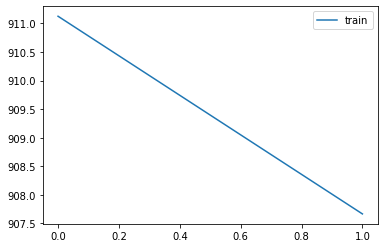

In [ ]:
# n_train_hours = -30 
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

  # split into input and outputs
train_X, train_y = train_all_flat[:, :-1],  train_all_flat[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)



model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(500,return_sequences=True ))
# model.add(LSTM(500, ))
model.add(Dense(1))
model.compile(loss= root_mean_squared_error, optimizer='adam')

history = model.fit(train_X, train_y, epochs=2, batch_size=72, 
                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# yhat = model.predict(test_X)
# yhat = yhat.reshape(-1)
# if np.isnan(yhat).any():
#   continue
# print("Region of Interest", region_of_interest)
# print("RMSE is - ", sqrt(mean_squared_error(test_y, yhat)))
# print('mae is : ', mean_absolute_error(test_y, yhat))
# print('mean relative error is : ',relative_error_dl(yhat, test_y), 
#           "for a forecast of ", len(yhat), " days.")
  
# rmse = sqrt(mean_squared_error(test_y, yhat))
# mae = mean_absolute_error(test_y, yhat)
# mre = relative_error_dl(yhat, test_y)
# error = [rmse, mae, mre]
# error_dict[region_of_interest] = error
# print(error)


In [ ]:
model.save('/content/drive/MyDrive/CMU/global_model_actual_cases')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CMU/global_model_actual_cases/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CMU/global_model_actual_cases/assets


In [ ]:
# copy = keras.models.load_model('/content/drive/MyDrive/CMU/global_model', 
#                                custom_objects= {'root_mean_squared_error':root_mean_squared_error})

(687, 1, 11) (687,) (30, 1, 11) (30,)
(717, 12)
(717, 12)
Epoch 1/2


10/10 - 2s - loss: 41.2099 - val_loss: 76.0686
Epoch 2/2
10/10 - 0s - loss: 41.1422 - val_loss: 75.9947


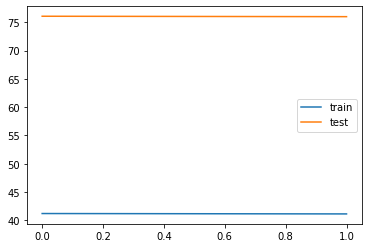

Region of Interest ak
RMSE is -  75.99469939369126
mae is :  67.85472
mean relative error is :  89.57613706588745 for a forecast of  30  days.
[75.99469939369126, 67.85472, 89.57613706588745]
(1664, 1, 11) (1664,) (30, 1, 11) (30,)
(1694, 12)
(1694, 12)
Epoch 1/2


24/24 - 2s - loss: 922.1733 - val_loss: 654.6964
Epoch 2/2
24/24 - 0s - loss: 921.7828 - val_loss: 654.4963


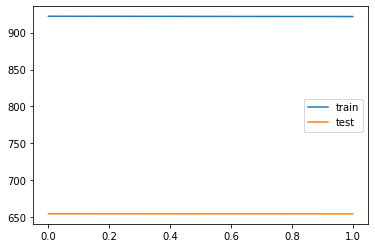

Region of Interest al
RMSE is -  654.4963951390413
mae is :  649.72034
mean relative error is :  99.79415535926819 for a forecast of  30  days.
[654.4963951390413, 649.72034, 99.79415535926819]
(1550, 1, 11) (1550,) (30, 1, 11) (30,)
(1580, 12)
(1580, 12)
Epoch 1/2


22/22 - 2s - loss: 467.5088 - val_loss: 523.7567
Epoch 2/2
22/22 - 0s - loss: 467.3876 - val_loss: 523.6417


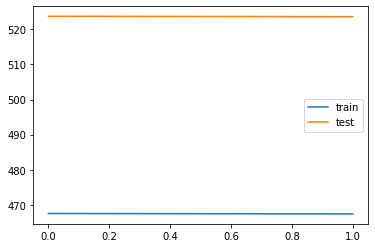

Region of Interest ar
RMSE is -  523.6416355676848
mae is :  505.26962
mean relative error is :  99.77432489395142 for a forecast of  30  days.
[523.6416355676848, 505.26962, 99.77432489395142]
(1704, 1, 11) (1704,) (30, 1, 11) (30,)
(1734, 12)
(1734, 12)
Epoch 1/2


24/24 - 2s - loss: 1470.1497 - val_loss: 184.0162
Epoch 2/2
24/24 - 0s - loss: 1470.1061 - val_loss: 183.9690


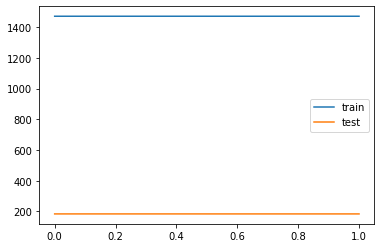

Region of Interest az
RMSE is -  183.96903399417522
mae is :  168.74129
mean relative error is :  99.0653932094574 for a forecast of  30  days.
[183.96903399417522, 168.74129, 99.0653932094574]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 2s - loss: 5026.3125 - val_loss: 3016.7065
Epoch 2/2
24/24 - 0s - loss: 5026.1895 - val_loss: 3016.6211


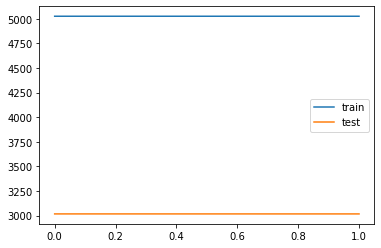

Region of Interest ca
RMSE is -  3016.6212887931424
mae is :  2984.0835
mean relative error is :  99.96799230575562 for a forecast of  30  days.
[3016.6212887931424, 2984.0835, 99.96799230575562]
(3456, 1, 11) (3456,) (30, 1, 11) (30,)
(3486, 12)
(3486, 12)
Epoch 1/2


48/48 - 2s - loss: 358.8868 - val_loss: 293.5552
Epoch 2/2
48/48 - 0s - loss: 358.7522 - val_loss: 293.4283


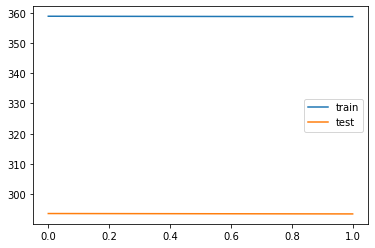

Region of Interest co
RMSE is -  293.4283078964945
mae is :  258.00986
mean relative error is :  90.46803712844849 for a forecast of  30  days.
[293.4283078964945, 258.00986, 90.46803712844849]
(267, 1, 11) (267,) (30, 1, 11) (30,)
(297, 12)
(297, 12)
Epoch 1/2


4/4 - 2s - loss: 82.1950 - val_loss: 114.5326
Epoch 2/2
4/4 - 0s - loss: 82.1894 - val_loss: 114.5275


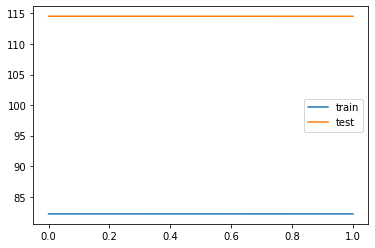

Region of Interest dc
RMSE is -  114.52746838913798
mae is :  100.88117
mean relative error is :  98.59934449195862 for a forecast of  30  days.
[114.52746838913798, 100.88117, 98.59934449195862]
(1017, 1, 11) (1017,) (30, 1, 11) (30,)
(1047, 12)
(1047, 12)
Epoch 1/2


15/15 - 2s - loss: 131.0468 - val_loss: 83.6589
Epoch 2/2
15/15 - 0s - loss: 131.0170 - val_loss: 83.6320


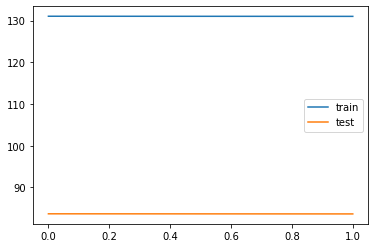

Region of Interest de
RMSE is -  83.63198015991699
mae is :  61.807095
mean relative error is :  30.04709780216217 for a forecast of  30  days.
[83.63198015991699, 61.807095, 30.04709780216217]
(1721, 1, 11) (1721,) (30, 1, 11) (30,)
(1751, 12)
(1751, 12)
Epoch 1/2


24/24 - 2s - loss: 4451.2905 - val_loss: 1998.0519
Epoch 2/2
24/24 - 0s - loss: 4451.1992 - val_loss: 1997.9669


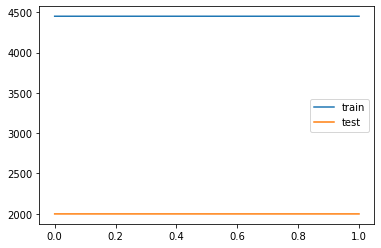

Region of Interest fl
RMSE is -  1997.9669041302961
mae is :  1976.2965
mean relative error is :  99.90205764770508 for a forecast of  30  days.
[1997.9669041302961, 1976.2965, 99.90205764770508]
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(1747, 12)
(1747, 12)
Epoch 1/2


24/24 - 3s - loss: 1802.9569 - val_loss: 1180.5920
Epoch 2/2
24/24 - 0s - loss: 1802.8407 - val_loss: 1180.5034


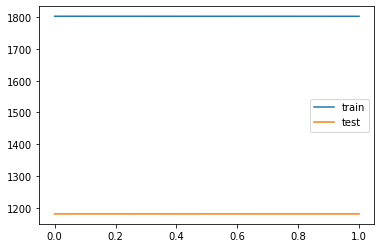

Region of Interest ga
RMSE is -  1180.5033883898852
mae is :  1088.8813
mean relative error is :  99.85209703445435 for a forecast of  30  days.
[1180.5033883898852, 1088.8813, 99.85209703445435]
(933, 1, 11) (933,) (30, 1, 11) (30,)
(963, 12)
(963, 12)
Epoch 1/2


13/13 - 2s - loss: 58.9385 - val_loss: 211.3613
Epoch 2/2
13/13 - 0s - loss: 58.8320 - val_loss: 211.2487


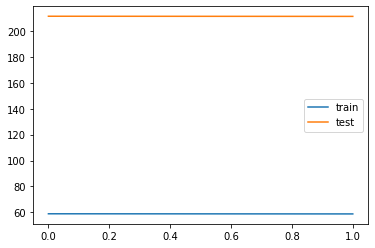

Region of Interest hi
RMSE is -  211.2487333541908
mae is :  202.17253
mean relative error is :  99.48399662971497 for a forecast of  30  days.
[211.2487333541908, 202.17253, 99.48399662971497]
(1683, 1, 11) (1683,) (30, 1, 11) (30,)
(1713, 12)
(1713, 12)
Epoch 1/2


24/24 - 2s - loss: 503.1452 - val_loss: 442.8633
Epoch 2/2
24/24 - 0s - loss: 502.9088 - val_loss: 442.6053


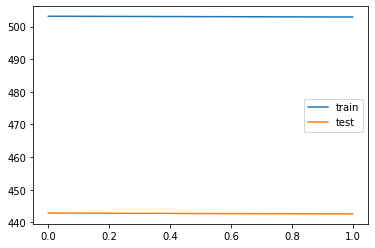

Region of Interest ia
RMSE is -  442.6053546897055
mae is :  434.6489
mean relative error is :  99.6926486492157 for a forecast of  30  days.
[442.6053546897055, 434.6489, 99.6926486492157]
(1419, 1, 11) (1419,) (30, 1, 11) (30,)
(1449, 12)
(1449, 12)
Epoch 1/2


20/20 - 2s - loss: 229.5304 - val_loss: 208.6687
Epoch 2/2
20/20 - 0s - loss: 229.3579 - val_loss: 208.5070


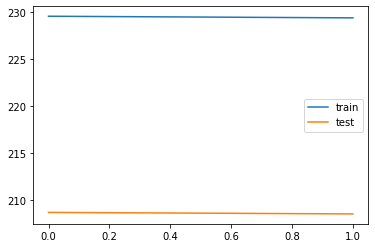

Region of Interest id
RMSE is -  208.50700677675079
mae is :  185.2622
mean relative error is :  99.30018782615662 for a forecast of  30  days.
[208.50700677675079, 185.2622, 99.30018782615662]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 2s - loss: 1622.7709 - val_loss: 1457.5706
Epoch 2/2
24/24 - 0s - loss: 1622.5627 - val_loss: 1457.4479


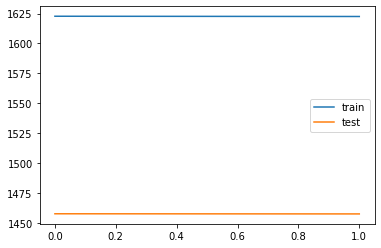

Region of Interest il
RMSE is -  1457.4478549848704
mae is :  1453.5101
mean relative error is :  99.89694952964783 for a forecast of  30  days.
[1457.4478549848704, 1453.5101, 99.89694952964783]
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(1747, 12)
(1747, 12)
Epoch 1/2


24/24 - 2s - loss: 656.9733 - val_loss: 584.7013
Epoch 2/2
24/24 - 0s - loss: 656.8917 - val_loss: 584.6028


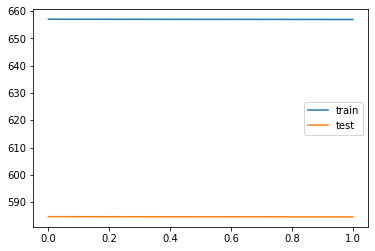

Region of Interest in
RMSE is -  584.602856647143
mae is :  560.22046
mean relative error is :  99.7370719909668 for a forecast of  30  days.
[584.602856647143, 560.22046, 99.7370719909668]
(1618, 1, 11) (1618,) (30, 1, 11) (30,)
(1648, 12)
(1648, 12)
Epoch 1/2


23/23 - 2s - loss: 396.6778 - val_loss: 834.6654
Epoch 2/2
23/23 - 0s - loss: 396.4706 - val_loss: 834.5651


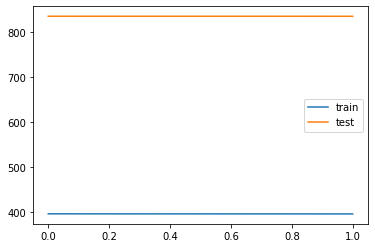

Region of Interest ks
RMSE is -  834.5651187894208
mae is :  714.3482
mean relative error is :  99.6307909488678 for a forecast of  30  days.
[834.5651187894208, 714.3482, 99.6307909488678]
(1678, 1, 11) (1678,) (30, 1, 11) (30,)
(1708, 12)
(1708, 12)
Epoch 1/2


24/24 - 2s - loss: 397.7533 - val_loss: 312.3850
Epoch 2/2
24/24 - 0s - loss: 397.6715 - val_loss: 312.2990


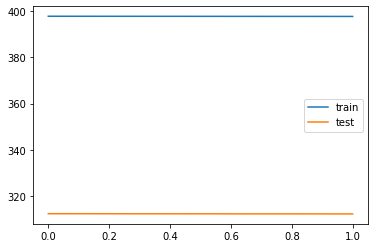

Region of Interest ky
RMSE is -  312.2989603328836
mae is :  299.43515
mean relative error is :  99.35876131057739 for a forecast of  30  days.
[312.2989603328836, 299.43515, 99.35876131057739]
(1660, 1, 11) (1660,) (30, 1, 11) (30,)
(1690, 12)
(1690, 12)
Epoch 1/2


24/24 - 2s - loss: 1040.8287 - val_loss: 760.5978
Epoch 2/2
24/24 - 0s - loss: 1040.6923 - val_loss: 760.4418


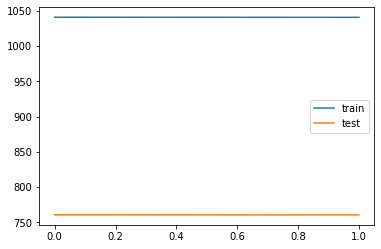

Region of Interest la
RMSE is -  760.4417712750925
mae is :  579.2216
mean relative error is :  99.70008134841919 for a forecast of  30  days.
[760.4417712750925, 579.2216, 99.70008134841919]
(1711, 1, 11) (1711,) (30, 1, 11) (30,)
(1741, 12)
(1741, 12)
Epoch 1/2


24/24 - 2s - loss: 851.7037 - val_loss: 243.3792
Epoch 2/2
24/24 - 0s - loss: 851.6614 - val_loss: 243.3062


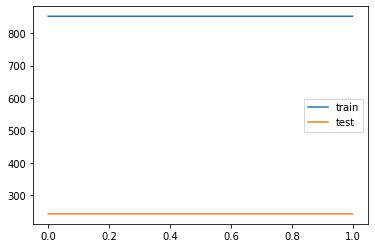

Region of Interest ma
RMSE is -  243.306214599011
mae is :  232.65332
mean relative error is :  99.29799437522888 for a forecast of  30  days.
[243.306214599011, 232.65332, 99.29799437522888]
(1680, 1, 11) (1680,) (30, 1, 11) (30,)
(1710, 12)
(1710, 12)
Epoch 1/2


24/24 - 2s - loss: 731.4595 - val_loss: 590.1127
Epoch 2/2
24/24 - 0s - loss: 731.4153 - val_loss: 590.0407


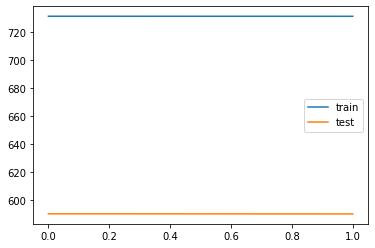

Region of Interest md
RMSE is -  590.0407295263608
mae is :  552.16656
mean relative error is :  99.74731206893921 for a forecast of  30  days.
[590.0407295263608, 552.16656, 99.74731206893921]
(1380, 1, 11) (1380,) (30, 1, 11) (30,)
(1410, 12)
(1410, 12)
Epoch 1/2


20/20 - 2s - loss: 29.0261 - val_loss: 23.0756
Epoch 2/2
20/20 - 0s - loss: 28.7777 - val_loss: 22.8684


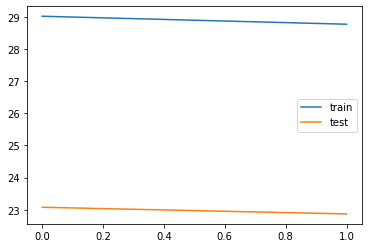

Region of Interest me
RMSE is -  22.868365883970043
mae is :  20.222681
mean relative error is :  88.71918320655823 for a forecast of  30  days.
[22.868365883970043, 20.222681, 88.71918320655823]
(1726, 1, 11) (1726,) (30, 1, 11) (30,)
(1756, 12)
(1756, 12)
Epoch 1/2


24/24 - 2s - loss: 684.9277 - val_loss: 822.9430
Epoch 2/2
24/24 - 0s - loss: 684.6540 - val_loss: 822.7176


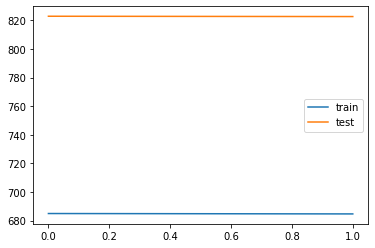

Region of Interest mi
RMSE is -  822.7176383790492
mae is :  768.99805
mean relative error is :  99.49032664299011 for a forecast of  30  days.
[822.7176383790492, 768.99805, 99.49032664299011]
(1705, 1, 11) (1705,) (30, 1, 11) (30,)
(1735, 12)
(1735, 12)
Epoch 1/2


24/24 - 2s - loss: 559.4493 - val_loss: 579.8409
Epoch 2/2
24/24 - 0s - loss: 559.2128 - val_loss: 579.6451


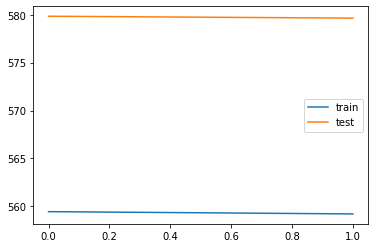

Region of Interest mn
RMSE is -  579.6450961579852
mae is :  562.6194
mean relative error is :  99.76040720939636 for a forecast of  30  days.
[579.6450961579852, 562.6194, 99.76040720939636]
(1706, 1, 11) (1706,) (30, 1, 11) (30,)
(1736, 12)
(1736, 12)
Epoch 1/2


24/24 - 2s - loss: 635.9297 - val_loss: 1115.5284
Epoch 2/2
24/24 - 0s - loss: 635.7796 - val_loss: 1115.3827


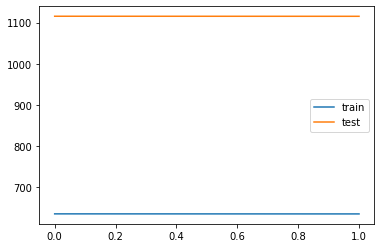

Region of Interest mo
RMSE is -  1115.3826697595762
mae is :  1101.5182
mean relative error is :  99.8940646648407 for a forecast of  30  days.
[1115.3826697595762, 1101.5182, 99.8940646648407]
(1514, 1, 11) (1514,) (30, 1, 11) (30,)
(1544, 12)
(1544, 12)
Epoch 1/2


22/22 - 3s - loss: 609.4904 - val_loss: 325.6989
Epoch 2/2
22/22 - 0s - loss: 609.2828 - val_loss: 325.4892


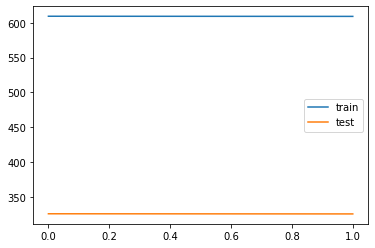

Region of Interest ms
RMSE is -  325.48913912371944
mae is :  315.3913
mean relative error is :  99.48481917381287 for a forecast of  30  days.
[325.48913912371944, 315.3913, 99.48481917381287]
(1169, 1, 11) (1169,) (30, 1, 11) (30,)
(1199, 12)
(1199, 12)
Epoch 1/2


17/17 - 2s - loss: 51.7789 - val_loss: 92.7001
Epoch 2/2
17/17 - 0s - loss: 51.7086 - val_loss: 92.6153


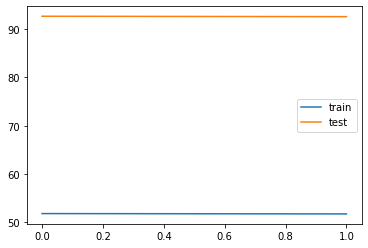

Region of Interest mt
RMSE is -  92.61533666697703
mae is :  79.696
mean relative error is :  94.3798840045929 for a forecast of  30  days.
[92.61533666697703, 79.696, 94.3798840045929]
(1721, 1, 11) (1721,) (30, 1, 11) (30,)
(1751, 12)
(1751, 12)
Epoch 1/2


24/24 - 2s - loss: 1220.0012 - val_loss: 1008.0646
Epoch 2/2
24/24 - 0s - loss: 1219.6974 - val_loss: 1007.7567


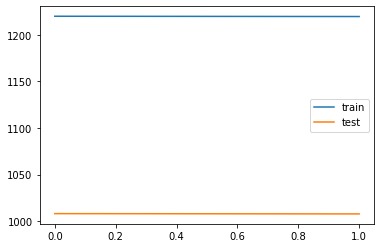

Region of Interest nc
RMSE is -  1007.7566050391334
mae is :  1005.9881
mean relative error is :  99.79979395866394 for a forecast of  30  days.
[1007.7566050391334, 1005.9881, 99.79979395866394]
(689, 1, 11) (689,) (30, 1, 11) (30,)
(719, 12)
(719, 12)
Epoch 1/2


10/10 - 2s - loss: 76.1078 - val_loss: 225.9153
Epoch 2/2
10/10 - 0s - loss: 76.0825 - val_loss: 225.8960


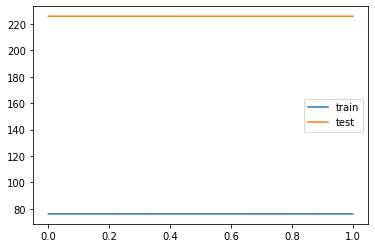

Region of Interest nd
RMSE is -  225.8960110592925
mae is :  204.7714
mean relative error is :  99.34026598930359 for a forecast of  30  days.
[225.8960110592925, 204.7714, 99.34026598930359]
(1468, 1, 11) (1468,) (30, 1, 11) (30,)
(1498, 12)
(1498, 12)
Epoch 1/2


21/21 - 2s - loss: 250.2237 - val_loss: 374.9374
Epoch 2/2
21/21 - 0s - loss: 249.9869 - val_loss: 374.7925


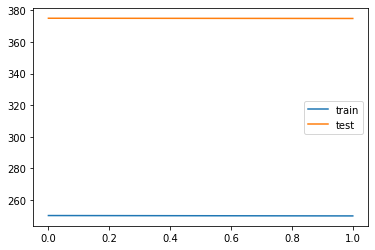

Region of Interest ne
RMSE is -  374.79252593935223
mae is :  292.1815
mean relative error is :  98.70203733444214 for a forecast of  30  days.
[374.79252593935223, 292.1815, 98.70203733444214]
(1366, 1, 11) (1366,) (30, 1, 11) (30,)
(1396, 12)
(1396, 12)
Epoch 1/2


19/19 - 2s - loss: 48.6479 - val_loss: 41.9622
Epoch 2/2
19/19 - 0s - loss: 48.5266 - val_loss: 41.8191


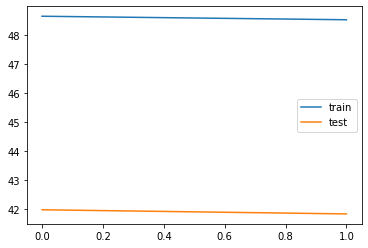

Region of Interest nh
RMSE is -  41.81910331826533
mae is :  34.04503
mean relative error is :  97.98277020454407 for a forecast of  30  days.
[41.81910331826533, 34.04503, 97.98277020454407]
(1716, 1, 11) (1716,) (30, 1, 11) (30,)
(1746, 12)
(1746, 12)
Epoch 1/2


24/24 - 2s - loss: 904.5121 - val_loss: 306.5905
Epoch 2/2
24/24 - 0s - loss: 904.3264 - val_loss: 306.3876


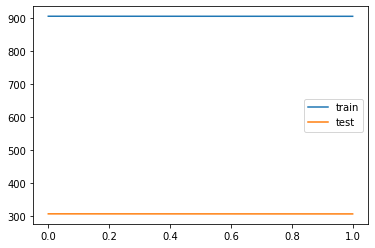

Region of Interest nj
RMSE is -  306.38763488838777
mae is :  305.38474
mean relative error is :  99.53470230102539 for a forecast of  30  days.
[306.38763488838777, 305.38474, 99.53470230102539]
(1338, 1, 11) (1338,) (30, 1, 11) (30,)
(1368, 12)
(1368, 12)
Epoch 1/2


19/19 - 2s - loss: 179.6557 - val_loss: 79.0735
Epoch 2/2
19/19 - 0s - loss: 179.5390 - val_loss: 78.9406


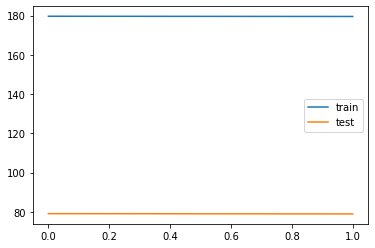

Region of Interest nm
RMSE is -  78.94060205207299
mae is :  66.756516
mean relative error is :  97.3510205745697 for a forecast of  30  days.
[78.94060205207299, 66.756516, 97.3510205745697]
(1479, 1, 11) (1479,) (30, 1, 11) (30,)
(1509, 12)
(1509, 12)
Epoch 1/2


21/21 - 2s - loss: 493.5304 - val_loss: 352.1505
Epoch 2/2
21/21 - 0s - loss: 493.3619 - val_loss: 352.0561


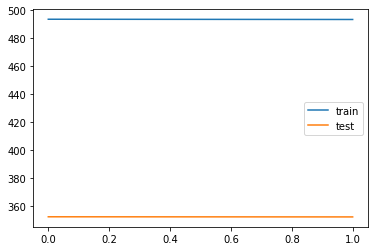

Region of Interest nv
RMSE is -  352.05609238798866
mae is :  313.60095
mean relative error is :  99.21522736549377 for a forecast of  30  days.
[352.05609238798866, 313.60095, 99.21522736549377]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 2s - loss: 1614.3121 - val_loss: 583.5000
Epoch 2/2
24/24 - 0s - loss: 1614.2378 - val_loss: 583.3165


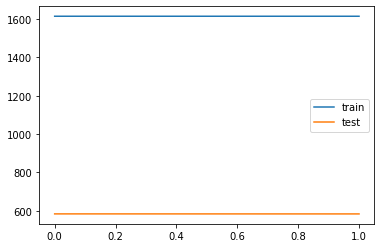

Region of Interest ny
RMSE is -  583.3165146384937
mae is :  578.2658
mean relative error is :  99.76562261581421 for a forecast of  30  days.
[583.3165146384937, 578.2658, 99.76562261581421]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 3s - loss: 866.1914 - val_loss: 730.2186
Epoch 2/2
24/24 - 0s - loss: 865.9760 - val_loss: 729.8282


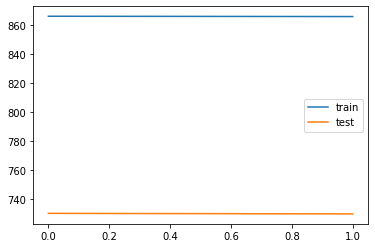

Region of Interest oh
RMSE is -  729.8281903982607
mae is :  727.42975
mean relative error is :  99.75396990776062 for a forecast of  30  days.
[729.8281903982607, 727.42975, 99.75396990776062]
(1674, 1, 11) (1674,) (30, 1, 11) (30,)
(1704, 12)
(1704, 12)
Epoch 1/2


24/24 - 2s - loss: 442.1997 - val_loss: 662.0345
Epoch 2/2
24/24 - 0s - loss: 442.0741 - val_loss: 661.8705


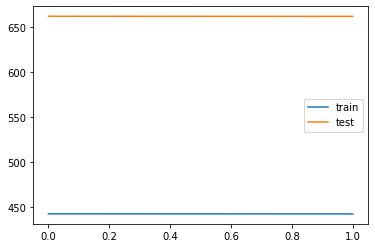

Region of Interest ok
RMSE is -  661.870597246924
mae is :  641.3053
mean relative error is :  99.68715906143188 for a forecast of  30  days.
[661.870597246924, 641.3053, 99.68715906143188]
(1664, 1, 11) (1664,) (30, 1, 11) (30,)
(1694, 12)
(1694, 12)
Epoch 1/2


24/24 - 3s - loss: 187.3746 - val_loss: 164.7345
Epoch 2/2
24/24 - 0s - loss: 187.2454 - val_loss: 164.6103


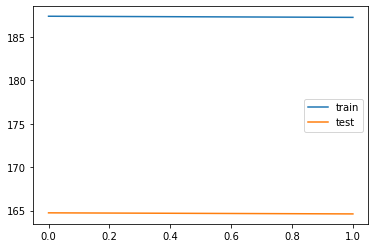

Region of Interest or
RMSE is -  164.61029380972806
mae is :  163.7806
mean relative error is :  99.37554597854614 for a forecast of  30  days.
[164.61029380972806, 163.7806, 99.37554597854614]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 2s - loss: 831.2144 - val_loss: 643.9973
Epoch 2/2
24/24 - 0s - loss: 831.1548 - val_loss: 643.9142


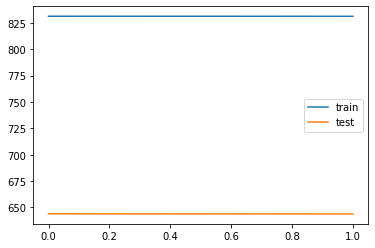

Region of Interest pa
RMSE is -  643.9141780936338
mae is :  635.906
mean relative error is :  99.85602498054504 for a forecast of  30  days.
[643.9141780936338, 635.906, 99.85602498054504]
(1009, 1, 11) (1009,) (30, 1, 11) (30,)
(1039, 12)
(1039, 12)
Epoch 1/2


15/15 - 2s - loss: 156.6344 - val_loss: 129.5026
Epoch 2/2
15/15 - 0s - loss: 156.6131 - val_loss: 129.4571


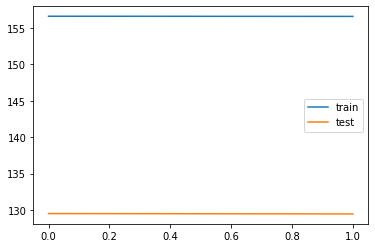

Region of Interest ri
RMSE is -  129.45710709777583
mae is :  72.72704
mean relative error is :  52.412062883377075 for a forecast of  30  days.
[129.45710709777583, 72.72704, 52.412062883377075]
(1692, 1, 11) (1692,) (30, 1, 11) (30,)
(1722, 12)
(1722, 12)
Epoch 1/2


24/24 - 2s - loss: 860.0487 - val_loss: 554.4601
Epoch 2/2
24/24 - 0s - loss: 859.9410 - val_loss: 554.3181


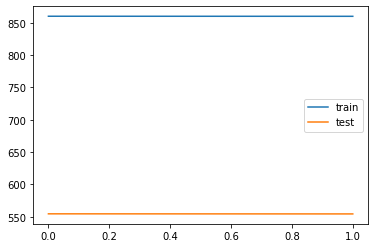

Region of Interest sc
RMSE is -  554.3181340620204
mae is :  526.82056
mean relative error is :  99.65566396713257 for a forecast of  30  days.
[554.3181340620204, 526.82056, 99.65566396713257]
(884, 1, 11) (884,) (30, 1, 11) (30,)
(914, 12)
(914, 12)
Epoch 1/2


13/13 - 2s - loss: 87.7568 - val_loss: 231.6100
Epoch 2/2
13/13 - 0s - loss: 87.6053 - val_loss: 231.4019


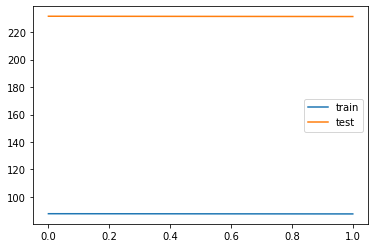

Region of Interest sd
RMSE is -  231.40191800469157
mae is :  220.34056
mean relative error is :  99.08145070075989 for a forecast of  30  days.
[231.40191800469157, 220.34056, 99.08145070075989]
(1710, 1, 11) (1710,) (30, 1, 11) (30,)
(1740, 12)
(1740, 12)
Epoch 1/2


24/24 - 2s - loss: 1117.7081 - val_loss: 1048.1185
Epoch 2/2
24/24 - 0s - loss: 1117.6272 - val_loss: 1048.0337


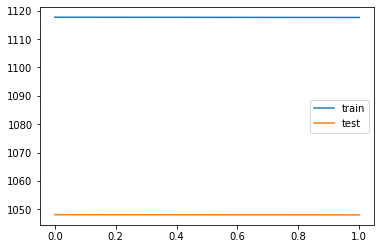

Region of Interest tn
RMSE is -  1048.0336945919248
mae is :  975.40393
mean relative error is :  99.85857605934143 for a forecast of  30  days.
[1048.0336945919248, 975.40393, 99.85857605934143]
(1722, 1, 11) (1722,) (30, 1, 11) (30,)
(1752, 12)
(1752, 12)
Epoch 1/2


24/24 - 2s - loss: 4617.3203 - val_loss: 2879.9341
Epoch 2/2
24/24 - 0s - loss: 4617.2344 - val_loss: 2879.7961


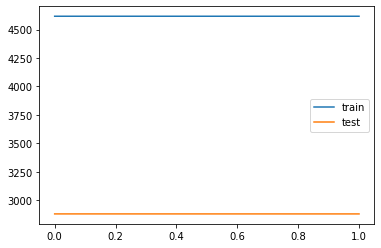

Region of Interest tx
RMSE is -  2879.796260154527
mae is :  2453.4136
mean relative error is :  99.8883605003357 for a forecast of  30  days.
[2879.796260154527, 2453.4136, 99.8883605003357]
(1655, 1, 11) (1655,) (30, 1, 11) (30,)
(1685, 12)
(1685, 12)
Epoch 1/2


23/23 - 2s - loss: 373.8461 - val_loss: 344.0784
Epoch 2/2
23/23 - 0s - loss: 373.7640 - val_loss: 343.9485


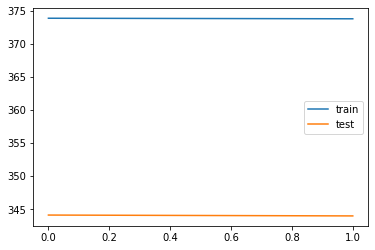

Region of Interest ut
RMSE is -  343.94851086318135
mae is :  335.67737
mean relative error is :  99.70728754997253 for a forecast of  30  days.
[343.94851086318135, 335.67737, 99.70728754997253]
(1724, 1, 11) (1724,) (30, 1, 11) (30,)
(1754, 12)
(1754, 12)
Epoch 1/2


24/24 - 2s - loss: 855.8760 - val_loss: 841.4160
Epoch 2/2
24/24 - 0s - loss: 855.8137 - val_loss: 841.3521


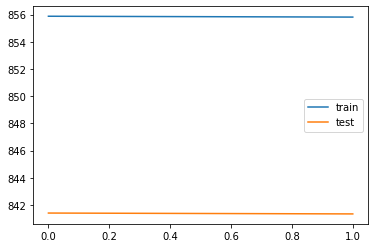

Region of Interest va
RMSE is -  841.352074045105
mae is :  821.20496
mean relative error is :  99.90130662918091 for a forecast of  30  days.
[841.352074045105, 821.20496, 99.90130662918091]
(732, 1, 11) (732,) (30, 1, 11) (30,)
(762, 12)
(762, 12)
Epoch 1/2


11/11 - 2s - loss: 7.3641 - val_loss: 6.7580
Epoch 2/2
11/11 - 0s - loss: 7.2747 - val_loss: 6.6928


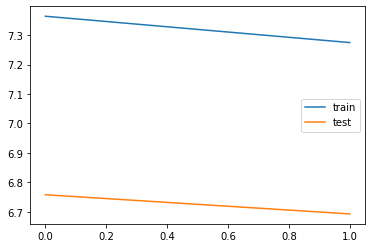

Region of Interest vt
RMSE is -  6.69284613995608
mae is :  4.9540386
mean relative error is :  66.4908766746521 for a forecast of  30  days.
[6.69284613995608, 4.9540386, 66.4908766746521]
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(1747, 12)
(1747, 12)
Epoch 1/2


24/24 - 3s - loss: 505.8977 - val_loss: 419.8710
Epoch 2/2
24/24 - 0s - loss: 505.8493 - val_loss: 419.7876


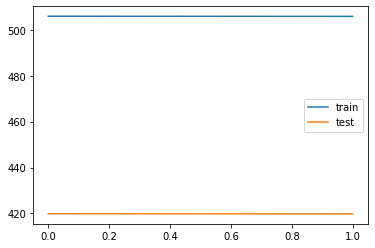

Region of Interest wa
RMSE is -  419.78761371079065
mae is :  365.41522
mean relative error is :  99.51712489128113 for a forecast of  30  days.
[419.78761371079065, 365.41522, 99.51712489128113]
(1717, 1, 11) (1717,) (30, 1, 11) (30,)
(1747, 12)
(1747, 12)
Epoch 1/2


24/24 - 2s - loss: 603.2259 - val_loss: 717.3422
Epoch 2/2
24/24 - 0s - loss: 603.1656 - val_loss: 717.2457


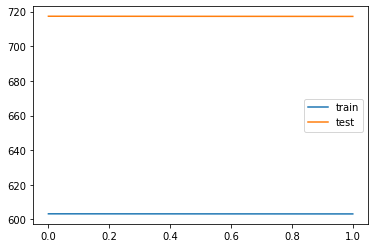

Region of Interest wi
RMSE is -  717.2457084221558
mae is :  707.21454
mean relative error is :  99.82951879501343 for a forecast of  30  days.
[717.2457084221558, 707.21454, 99.82951879501343]
(1467, 1, 11) (1467,) (30, 1, 11) (30,)
(1497, 12)
(1497, 12)
Epoch 1/2


21/21 - 2s - loss: 74.2056 - val_loss: 153.4426
Epoch 2/2
21/21 - 0s - loss: 73.8375 - val_loss: 153.1303


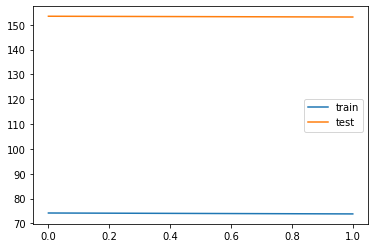

Region of Interest wv
RMSE is -  153.13035067182142
mae is :  142.42952
mean relative error is :  97.94042110443115 for a forecast of  30  days.
[153.13035067182142, 142.42952, 97.94042110443115]
(523, 1, 11) (523,) (30, 1, 11) (30,)
(553, 12)
(553, 12)
Epoch 1/2


8/8 - 2s - loss: 23.2089 - val_loss: 35.5240
Epoch 2/2
8/8 - 0s - loss: 23.1235 - val_loss: 35.4012


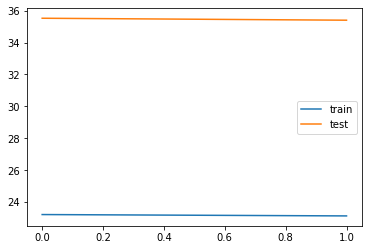

Region of Interest wy
RMSE is -  35.4011573731619
mae is :  31.510523
mean relative error is :  93.11860203742981 for a forecast of  30  days.
[35.4011573731619, 31.510523, 93.11860203742981]


In [ ]:
for region_of_interest in data_time['state_code'].unique():
  data_time['date'] = pd.to_datetime(data_time.date)
  data_ = data_time.drop(['date'], axis=1)
  data_.index = data_time.date
  data_ = data_[(data_.state_code == region_of_interest)]
  # data_ = data_.drop(columns = ['state_code', 'gender', 'age_bucket', 'bucket'])
  data_ = data_.drop(columns = ['state_code'])

  data_ = data_.dropna()


  data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted', 'daily_case']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
  values = data_.values
  values = values.astype('float32')
  reframed = series_to_supervised(values, 1, 1)

  n_train_hours = -30 
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  print(data_.shape)
  print(values.shape)

  model = Sequential()
  model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss= root_mean_squared_error, optimizer='adam')
  # model = keras.models.load_model('/content/drive/MyDrive/CMU/global_model_actual_cases', 
  #                              custom_objects= {'root_mean_squared_error':root_mean_squared_error})
  history = model.fit(train_X, train_y, epochs=2, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()


  yhat = model.predict(test_X)
  yhat = yhat.reshape(-1)
  if np.isnan(yhat).any():
    continue
  print("Region of Interest", region_of_interest)
  print("RMSE is - ", sqrt(mean_squared_error(test_y, yhat)))
  print('mae is : ', mean_absolute_error(test_y, yhat))
  print('mean relative error is : ',relative_error_dl(yhat, test_y), 
          "for a forecast of ", len(yhat), " days.")
  
  rmse = sqrt(mean_squared_error(test_y, yhat))
  mae = mean_absolute_error(test_y, yhat)
  mre = relative_error_dl(yhat, test_y)
  error = [rmse, mae, mre]
  error_dict[region_of_interest] = error
  print(error)


In [ ]:
# for region_of_interest in data_time['state_code'].unique():
#   data_time['date'] = pd.to_datetime(data_time.date)
#   data_ = data_time.drop(['date'], axis=1)
#   data_.index = data_time.date
#   data_ = data_[(data_.state_code == region_of_interest)]
#   # data_ = data_.drop(columns = ['state_code', 'gender', 'age_bucket', 'bucket'])
#   data_ = data_.drop(columns = ['state_code'])

#   data_ = data_.dropna()


#   data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
#     'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
#     'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
# #     'pct_worked_outside_home_weighted',
# #     'pct_cli_weighted']]
#   values = data_.values
#   values = values.astype('float32')
#   reframed = series_to_supervised(values, 1, 1)

#   n_train_hours = -30 
#   train = values[:n_train_hours, :]
#   test = values[n_train_hours:, :]

#   # split into input and outputs
#   train_X, train_y = train[:, :-1], train[:, -1]
#   test_X, test_y = test[:, :-1], test[:, -1]

#   # reshape input to be 3D [samples, timesteps, features]
#   train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#   test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#   print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


#   print(data_.shape)
#   print(values.shape)

#   # model = Sequential()
#   # model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
#   # model.add(Dense(1))
#   # model.compile(loss= root_mean_squared_error, optimizer='adam')

#   # history = model.fit(train_X, train_y, epochs=2, batch_size=72, 
#   #                   validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
#   # pyplot.plot(history.history['loss'], label='train')
#   # pyplot.plot(history.history['val_loss'], label='test')
#   # pyplot.legend()
#   # pyplot.show()


#   yhat = model.predict(test_X)
#   yhat = yhat.reshape(-1)
#   if np.isnan(yhat).any():
#     continue
#   print("Region of Interest", region_of_interest)
#   print("RMSE is - ", sqrt(mean_squared_error(test_y, yhat)))
#   print('mae is : ', mean_absolute_error(test_y, yhat))
#   print('mean relative error is : ',relative_error_dl(yhat, test_y), 
#           "for a forecast of ", len(yhat), " days.")
  
#   rmse = sqrt(mean_squared_error(test_y, yhat))
#   mae = mean_absolute_error(test_y, yhat)
#   mre = relative_error_dl(yhat, test_y)
#   error = [rmse, mae, mre]
#   error_dict[region_of_interest] = error
#   print(error)


(687, 1, 10) (687,) (30, 1, 10) (30,)
(717, 11)
(717, 11)
Region of Interest ak
RMSE is -  0.8229573436936675
mae is :  0.6169894
mean relative error is :  34.85947251319885 for a forecast of  30  days.
[0.8229573436936675, 0.6169894, 34.85947251319885]
(1664, 1, 10) (1664,) (30, 1, 10) (30,)
(1694, 11)
(1694, 11)
Region of Interest al
RMSE is -  1.3930003848845531
mae is :  1.1665858
mean relative error is :  36.470964550971985 for a forecast of  30  days.
[1.3930003848845531, 1.1665858, 36.470964550971985]
(1550, 1, 10) (1550,) (30, 1, 10) (30,)
(1580, 11)
(1580, 11)
Region of Interest ar
RMSE is -  0.7537759460740856
mae is :  0.53903836
mean relative error is :  24.095669388771057 for a forecast of  30  days.
[0.7537759460740856, 0.53903836, 24.095669388771057]
(1704, 1, 10) (1704,) (30, 1, 10) (30,)
(1734, 11)
(1734, 11)
Region of Interest az
RMSE is -  0.8231482763337586
mae is :  0.71015817
mean relative error is :  32.76030123233795 for a forecast of  30  days.
[0.8231482763337

In [ ]:
Error_captured = pd.DataFrame.from_dict(error_dict).transpose()
# Error_captured

,0,1,2
ak,68.765950,60.170765,69.016069
al,646.393045,641.558777,98.522669
ar,515.427887,496.761017,97.969568
az,176.240181,160.334869,92.743796
ca,3008.006316,2975.388184,99.670333
co,286.556713,251.778091,172.891009
dc,107.012124,92.264908,86.805516
de,77.717880,58.756294,-29.147321
fl,1990.321582,1968.566162,99.504071
ga,1172.878990,1080.570923,98.880535


In [ ]:
Error_captured = pd.DataFrame.from_dict(error_dict).transpose()
# Error_captured

data_count_per_state = pd.DataFrame(data_time['state_code'].value_counts()).reset_index()
data_count_per_state.columns = ['state_code','count']

Error_captured = Error_captured.reset_index()
Error_captured.columns = ['state_code', 'rmse', 'mae', 'mre']

pd.merge(Error_captured, data_count_per_state, on = 'state_code').sort_values(by = 'count', 
                                                                              ascending = False).to_csv('./errors_state_wise_local_model_actual_cases.csv', 
                                                                                                        index=False)

In [ ]:
pd.merge(Error_captured, data_count_per_state, 
         on = 'state_code').sort_values(by = 'count', ascending = False).to_csv('/content/drive/MyDrive/CMU/errors_state_wise_meta_model.csv', 
                                                                                index=False)

### Run only till here!

In [ ]:
# model.predict(test_X)
# train_y

array([ 4.0267, 13.4495, 32.6639, ..., 17.8822, 16.5618, 16.5877],
      dtype=float32)

In [ ]:

# data_ = data_[(data_.bucket == bucket_of_interest)]
# data_ = data_.drop(columns = ['state_code','bucket', 'age_bucket', 'gender'])




## Global Model

(76764, 1, 10) (76764,) (30, 1, 10) (30,)
(76794, 11)
(76794, 11)
Epoch 1/2
1067/1067 - 4s - loss: 0.6335 - val_loss: 0.6731
Epoch 2/2
1067/1067 - 2s - loss: 0.6097 - val_loss: 0.5678


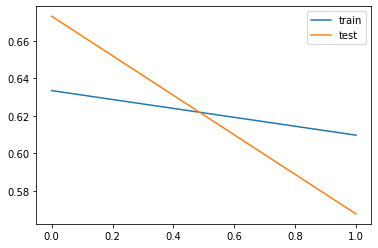

RMSE is -  0.5677838639810087
mae is :  0.48735034
mean relative error is :  42.70423650741577 for a forecast of  30  days.
[0.46538494565788935, 0.3667821, 31.34874701499939]


In [ ]:
  # region_of_interest = 'ca'
  data_time['date'] = pd.to_datetime(data_time.date)
  data_ = data_time.drop(['date'], axis=1)
  data_.index = data_time.date
  # data_ = data_[(data_.state_code == region_of_interest)]
  data_ = data_.drop(columns = ['state_code', 'age_bucket', 'gender','bucket'])
  data_ = data_.dropna()

  data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
  values = data_.values
  values = data_.values
  values = values.astype('float32')
  reframed = series_to_supervised(values, 1, 1)

  n_train_hours = -30 
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  print(data_.shape)
  print(values.shape)

  model = Sequential()
  model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss= root_mean_squared_error, optimizer='adam')

  history = model.fit(train_X, train_y, epochs=2, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()


  yhat = model.predict(test_X)
  yhat = yhat.reshape(-1)

  print("RMSE is - ", sqrt(mean_squared_error(test_y, yhat)))
  print('mae is : ', mean_absolute_error(test_y, yhat))
  print('mean relative error is : ',relative_error_dl(yhat, test_y), 
          "for a forecast of ", len(yhat), " days.")
  
  rmse = sqrt(mean_squared_error(test_y, yhat))
  mae = mean_absolute_error(test_y, yhat)
  mre = relative_error_dl(yhat, test_y)
  # error = [rmse, mae, mre]
  # error_dict[region_of_interest] = error
  print(error)


#### Predict for all states

In [ ]:
for region_of_interest in data_time['state_code'].unique():
  data_time['date'] = pd.to_datetime(data_time.date)
  data_ = data_time.drop(['date'], axis=1)
  data_.index = data_time.date
  data_ = data_[(data_.state_code == region_of_interest)]
  # data_ = data_.drop(columns = ['state_code', 'gender', 'age_bucket', 'bucket'])
  data_ = data_.drop(columns = ['state_code'])

  data_ = data_.dropna()


  data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
  values = data_.values
  values = values.astype('float32')
  reframed = series_to_supervised(values, 1, 1)

  n_train_hours = -30 
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  print(data_.shape)
  print(values.shape)

#   model = Sequential()
#   model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
#   model.add(Dense(1))
#   model.compile(loss= root_mean_squared_error, optimizer='adam')

#   history = model.fit(train_X, train_y, epochs=2, batch_size=72, 
#                     validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
#   pyplot.plot(history.history['loss'], label='train')
#   pyplot.plot(history.history['val_loss'], label='test')
#   pyplot.legend()
#   pyplot.show()


  yhat = model.predict(test_X)
  yhat = yhat.reshape(-1)
  if np.isnan(yhat).any():
    continue
  print("Region of Interest", region_of_interest)
  print("RMSE is - ", sqrt(mean_squared_error(test_y, yhat)))
  print('mae is : ', mean_absolute_error(test_y, yhat))
  print('mean relative error is : ',relative_error_dl(yhat, test_y), 
          "for a forecast of ", len(yhat), " days.")
  
  rmse = sqrt(mean_squared_error(test_y, yhat))
  mae = mean_absolute_error(test_y, yhat)
  mre = relative_error_dl(yhat, test_y)
  error = [rmse, mae, mre]
  error_dict[region_of_interest] = error
  print(error)


(687, 1, 10) (687,) (30, 1, 10) (30,)
(717, 11)
(717, 11)
Region of Interest ak
RMSE is -  0.7607657315059578
mae is :  0.68403715
mean relative error is :  51.65365934371948 for a forecast of  30  days.
[0.7607657315059578, 0.68403715, 51.65365934371948]
(1664, 1, 10) (1664,) (30, 1, 10) (30,)
(1694, 11)
(1694, 11)
Region of Interest al
RMSE is -  0.7744607803087973
mae is :  0.59876233
mean relative error is :  20.998165011405945 for a forecast of  30  days.
[0.7744607803087973, 0.59876233, 20.998165011405945]
(1550, 1, 10) (1550,) (30, 1, 10) (30,)
(1580, 11)
(1580, 11)
Region of Interest ar
RMSE is -  0.6866867934636784
mae is :  0.5298244
mean relative error is :  30.878576636314392 for a forecast of  30  days.
[0.6866867934636784, 0.5298244, 30.878576636314392]
(1704, 1, 10) (1704,) (30, 1, 10) (30,)
(1734, 11)
(1734, 11)
Region of Interest az
RMSE is -  0.48857384116878555
mae is :  0.3814315
mean relative error is :  20.794677734375 for a forecast of  30  days.
[0.4885738411687

In [ ]:
Error_captured = pd.DataFrame.from_dict(error_dict).transpose()
data_count_per_state = pd.DataFrame(data_time['state_code'].value_counts()).reset_index()
data_count_per_state.columns = ['state_code','count']
Error_captured = Error_captured.reset_index()
Error_captured.columns = ['state_code', 'rmse', 'mae', 'mre']
pd.merge(Error_captured, data_count_per_state, on = 'state_code').sort_values(by = 'count', ascending = False).to_csv('./errors_state_wise_global model.csv', index=False)

## Testing soemthing

In [ ]:
train_X_global = np.array()
for region_of_interest in data_time['state_code'].unique():
  data_time['date'] = pd.to_datetime(data_time.date)
  data_ = data_time.drop(['date'], axis=1)
  data_.index = data_time.date
  data_ = data_[(data_.state_code == region_of_interest)]
  # data_ = data_.drop(columns = ['state_code', 'gender', 'age_bucket', 'bucket'])
  data_ = data_.drop(columns = ['state_code'])

  data_ = data_.dropna()


  data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
  values = data_.values
  values = values.astype('float32')
  reframed = series_to_supervised(values, 1, 1)

  n_train_hours = -30 
  train = values[:n_train_hours, :]
  test = values[n_train_hours:, :]

  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


  print(data_.shape)
  print(values.shape)

  train_X_global = np.vstack((train_X, train_X_global))

TypeError: ignored

In [ ]:
region_of_interest = 'ca'
data_time['date'] = pd.to_datetime(data_time.date)
data_ = data_time.drop(['date'], axis=1)
data_.index = data_time.date
data_ = data_[(data_.state_code == region_of_interest)]
data_ = data_.drop(columns = ['state_code', 'age_bucket', 'gender','bucket'])
data_ = data_.dropna()

data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
values = data_.values
values = data_.values
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)

n_train_hours = -30 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

region_of_interest = 'fl'
data_time['date'] = pd.to_datetime(data_time.date)
data_ = data_time.drop(['date'], axis=1)
data_.index = data_time.date
data_ = data_[(data_.state_code == region_of_interest)]
data_ = data_.drop(columns = ['state_code', 'age_bucket', 'gender','bucket'])
data_ = data_.dropna()

data_ = data_[['pct_cmnty_cli_weighted','pct_self_anosmia_ageusia_weighted','pct_hh_cli_weighted',\
    'pct_hh_fever_weighted', 'pct_self_fever_weighted', 'pct_hh_sore_throat_weighted', 'pct_avoid_contact_all_or_most_time_weighted',\
    'pct_hh_difficulty_breathing_weighted','pct_self_persistent_pain_pressure_in_chest_weighted', 'pct_self_runny_nose_weighted','pct_tested_and_positive_weighted']]
#     'pct_worked_outside_home_weighted',
#     'pct_cli_weighted']]
values = data_.values
values = data_.values
values = values.astype('float32')
reframed = series_to_supervised(values, 1, 1)

n_train_hours = -30 
train_fl = values[:n_train_hours, :]
test_fl = values[n_train_hours:, :]



In [ ]:
test_fl

array([[20.9251,  1.919 ,  1.0957,  1.3604,  0.8879,  5.4774, 54.3941,
         2.94  ,  1.5978,  8.3485,  1.48  ],
       [20.8131,  1.6108,  1.1535,  1.6723,  0.7905,  6.2687, 53.0135,
         2.6737,  1.6837,  8.2785,  1.7538],
       [19.3325,  1.6758,  1.0682,  1.2444,  0.9337,  5.4377, 54.3317,
         3.4255,  1.8044,  7.8842,  1.5579],
       [18.9253,  1.8103,  1.5166,  2.0524,  1.2221,  6.5558, 53.3549,
         2.9589,  1.5154,  8.0524,  1.9386],
       [19.1684,  1.5047,  1.1179,  1.4532,  0.8085,  5.2493, 54.4464,
         3.529 ,  2.3489,  8.4506,  1.7749],
       [19.0141,  1.9382,  1.5534,  1.7755,  1.1523,  6.3843, 52.3117,
         3.4687,  2.0846,  9.0832,  1.5233],
       [17.99  ,  1.6166,  0.8596,  1.0873,  0.6962,  6.5527, 51.7672,
         2.8909,  1.4214,  7.1108,  1.2842],
       [17.8132,  1.7301,  1.3219,  1.5558,  0.9225,  5.4424, 52.3718,
         3.0249,  1.5629,  8.125 ,  1.1706],
       [17.0985,  1.0815,  0.7538,  0.9563,  0.4768,  5.4261, 52.184 ,
 

In [ ]:
np.vstack((test, test_fl))

array([[14.2294,  1.0924,  0.9678,  1.2963,  0.5691,  5.7358, 59.2087,
         2.3205,  1.1298,  7.6293,  1.1336],
       [14.9168,  1.5406,  1.2847,  1.6645,  0.8773,  6.1323, 60.8194,
         3.0897,  1.7036,  6.7702,  1.0083],
       [15.0162,  1.1709,  1.0881,  1.4162,  0.4743,  5.4223, 60.8846,
         3.3086,  1.7984,  7.0264,  1.0245],
       [14.1913,  1.3132,  0.9494,  1.2416,  0.7176,  5.92  , 59.2142,
         2.6258,  1.8792,  6.8926,  1.1405],
       [15.1361,  1.5473,  0.7568,  1.3943,  0.7266,  5.8616, 58.8552,
         2.599 ,  1.4459,  7.6085,  1.0703],
       [13.682 ,  0.8847,  1.0558,  1.3851,  0.7608,  5.6491, 58.5677,
         2.6168,  1.8793,  6.5286,  1.1316],
       [13.4999,  1.2806,  1.2746,  1.6796,  0.7729,  5.6065, 57.6564,
         2.7779,  1.5382,  6.4504,  0.9915],
       [13.8308,  1.4211,  1.067 ,  1.2237,  0.7299,  5.3424, 59.8019,
         3.1568,  1.766 ,  6.485 ,  1.157 ],
       [15.303 ,  1.1482,  0.9694,  1.1961,  0.8623,  5.194 , 58.7786,
 